In [ ]:
#!pip install pytesseract
#!pip install selenium
#!pip install openai
#!pip install webdriver_manager

In [1]:
# Save session cookies after manual login
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from apikey import tv_email, tv_password
import pickle

def save_cookies(url, username, password):
    # Set up WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")  # Open window maximized
    options.add_argument("--disable-notifications")  # Disable notifications
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    # Open the chart URL
    driver.get(url)

    # Wait for the chart to load
    WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'canvas[data-name="pane-canvas"]'))
    )

    # Click on the sign-in button
    sign_in_button = WebDriverWait(driver, 30).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, '.button-U2jIw4km > svg:nth-child(1)'))
    )
    sign_in_button.click()

    # Click on the email sign-in option
    email_sign_in_option = WebDriverWait(driver, 30).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, 'div.joinItem-U2jIw4km:nth-child(13)'))
    )
    email_sign_in_option.click()

    # Click on the Email button
    email_button = WebDriverWait(driver, 30).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, '.emailButton-nKAw8Hvt'))
    )
    email_button.click()

    # Enter credentials
    email_input = WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "#id_username"))
    )
    password_input = driver.find_element(By.CSS_SELECTOR, "#id_password")

    email_input.send_keys(username)  # Replace with your email
    password_input.send_keys(password)  # Replace with your password

    # Click the Sign In button using the correct CSS selector
    sign_in_button = WebDriverWait(driver, 30).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, '.submitButton-LQwxK8Bm'))
    )
    sign_in_button.click()

    # Wait for manual captcha solving
    print("Please solve the captcha manually and press Enter to continue...")
    input()

    # Save cookies to a file
    with open("cookies.pkl", "wb") as file:
        pickle.dump(driver.get_cookies(), file)

    driver.quit()

url = "https://www.tradingview.com/chart/CvaXuplE/?symbol=NASDAQ:TSLA"
save_cookies(url, tv_email, tv_password)

Please solve the captcha manually and press Enter to continue...


In [2]:
import os
from apikey import YOUR_API_KEY
from IPython.display import Image, display

In [3]:
def AIopinion(messages):
    from openai import OpenAI
    
    import re
    from IPython.display import clear_output
    
    client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
    
    try:
        response_stream = client.chat.completions.create(
            model="sonar-pro", #sonar-pro #sonar-reasoning-pro #sonar #sonar-reasoning
            messages=messages,
            stream=True,
        )
    
        full_response = []
        link_map = {}
        link_counter = 1
        buffer = ""
    
        for chunk in response_stream:
            if hasattr(chunk, 'citations') and chunk.citations:
                # Enumerate URLs starting at index 1 for proper citation numbering
                link_map = {str(i): url for i, url in enumerate(chunk.citations, start=1)}
            if chunk.choices and chunk.choices[0].delta.content:
                content = chunk.choices[0].delta.content
                buffer += content
                
                # Process URLs incrementally
                while True:
                    match = re.search(r'https?://[^\s\)\]\}]+', buffer)
                    if not match:
                        break
                        
                    url = match.group()
                    if url not in link_map:
                        link_map[url] = link_counter
                        link_counter += 1
                    
                    # Replace URL with reference marker
                    buffer = buffer.replace(url, f'[{link_map[url]}]', 1)
                
                # Print processed content and clear buffer
                print(buffer, end='', flush=True)
                full_response.append(buffer)
                buffer = ""
    
        # Print remaining buffer content
        if buffer:
            print(buffer, end='', flush=True)
            full_response.append(buffer)
    
        # Add references appendix
        print("\n\n--- References ---")
        for url, num in sorted(link_map.items(), key=lambda x: x[1]):
            print(f"[{num}] {url}")
    
    except Exception as e:
        clear_output()
        print(f"Error occurred: {str(e)}")

In [4]:
from PIL import Image as PILImage
import pytesseract  # First install: pip install pytesseract AND tesseract-OCR

# Convert image to analyzable text
def image_to_analysis(image_path):
    image = PILImage.open(image_path)
    text_data = pytesseract.image_to_string(image)
    
    # Clean up OCR results
    cleaned_data = "\n".join([line for line in text_data.split('\n') if line.strip()])
    return cleaned_data

In [8]:
# Load session cookies and take screenshot
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pickle
import time

def persist_chart_for_analysis(url, image_path):
    # Set up WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in background
    options.add_argument("--start-maximized")  # Open window maximized
    options.add_argument("--disable-notifications")  # Disable notifications
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    # Open the chart URL
    driver.get(url)

    # Load cookies from the file
    with open("cookies.pkl", "rb") as file:
        cookies = pickle.load(file)
        for cookie in cookies:
            driver.add_cookie(cookie)

    # Refresh the page to apply cookies
    driver.refresh()

    # Wait for the chart to load
    print("Waiting for the chart canvas to load...")
    WebDriverWait(driver, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'canvas[data-name="pane-canvas"]'))
    )
    
    # Wait for the specific indicator elements to load
    print("Waiting for the first indicator element to load...")
    WebDriverWait(driver, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.sources-l31H9iuA > div:nth-child(6)'))
    )
    print("Waiting for the Volume indicator to load...")
    WebDriverWait(driver, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.valueValue-l31H9iuA[title="Volume"]'))
    )
    print("Waiting for the EMA indicator to load...")
    WebDriverWait(driver, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.valueValue-l31H9iuA[title="EMA"]'))
    )

    # Take full-page screenshot
    print("Taking screenshot...")
    driver.save_screenshot(image_path)
    driver.quit()
    print("Screenshot saved to", image_path)


In [9]:
image_path = 'chart.png'
def generate_saved_chart_url(symbol):
    chart_id = "CvaXuplE"  # Your saved TradingView chart ID
    return f"https://www.tradingview.com/chart/{chart_id}/?symbol={symbol}"

# Example usage
symbol = "NASDAQ:TSLA"  # Change this dynamically
url = generate_saved_chart_url(symbol)
print(url)

https://www.tradingview.com/chart/CvaXuplE/?symbol=NASDAQ:TSLA


Waiting for the chart canvas to load...
Waiting for the first indicator element to load...
Waiting for the Volume indicator to load...
Waiting for the EMA indicator to load...
Taking screenshot...
Screenshot saved to chart.png


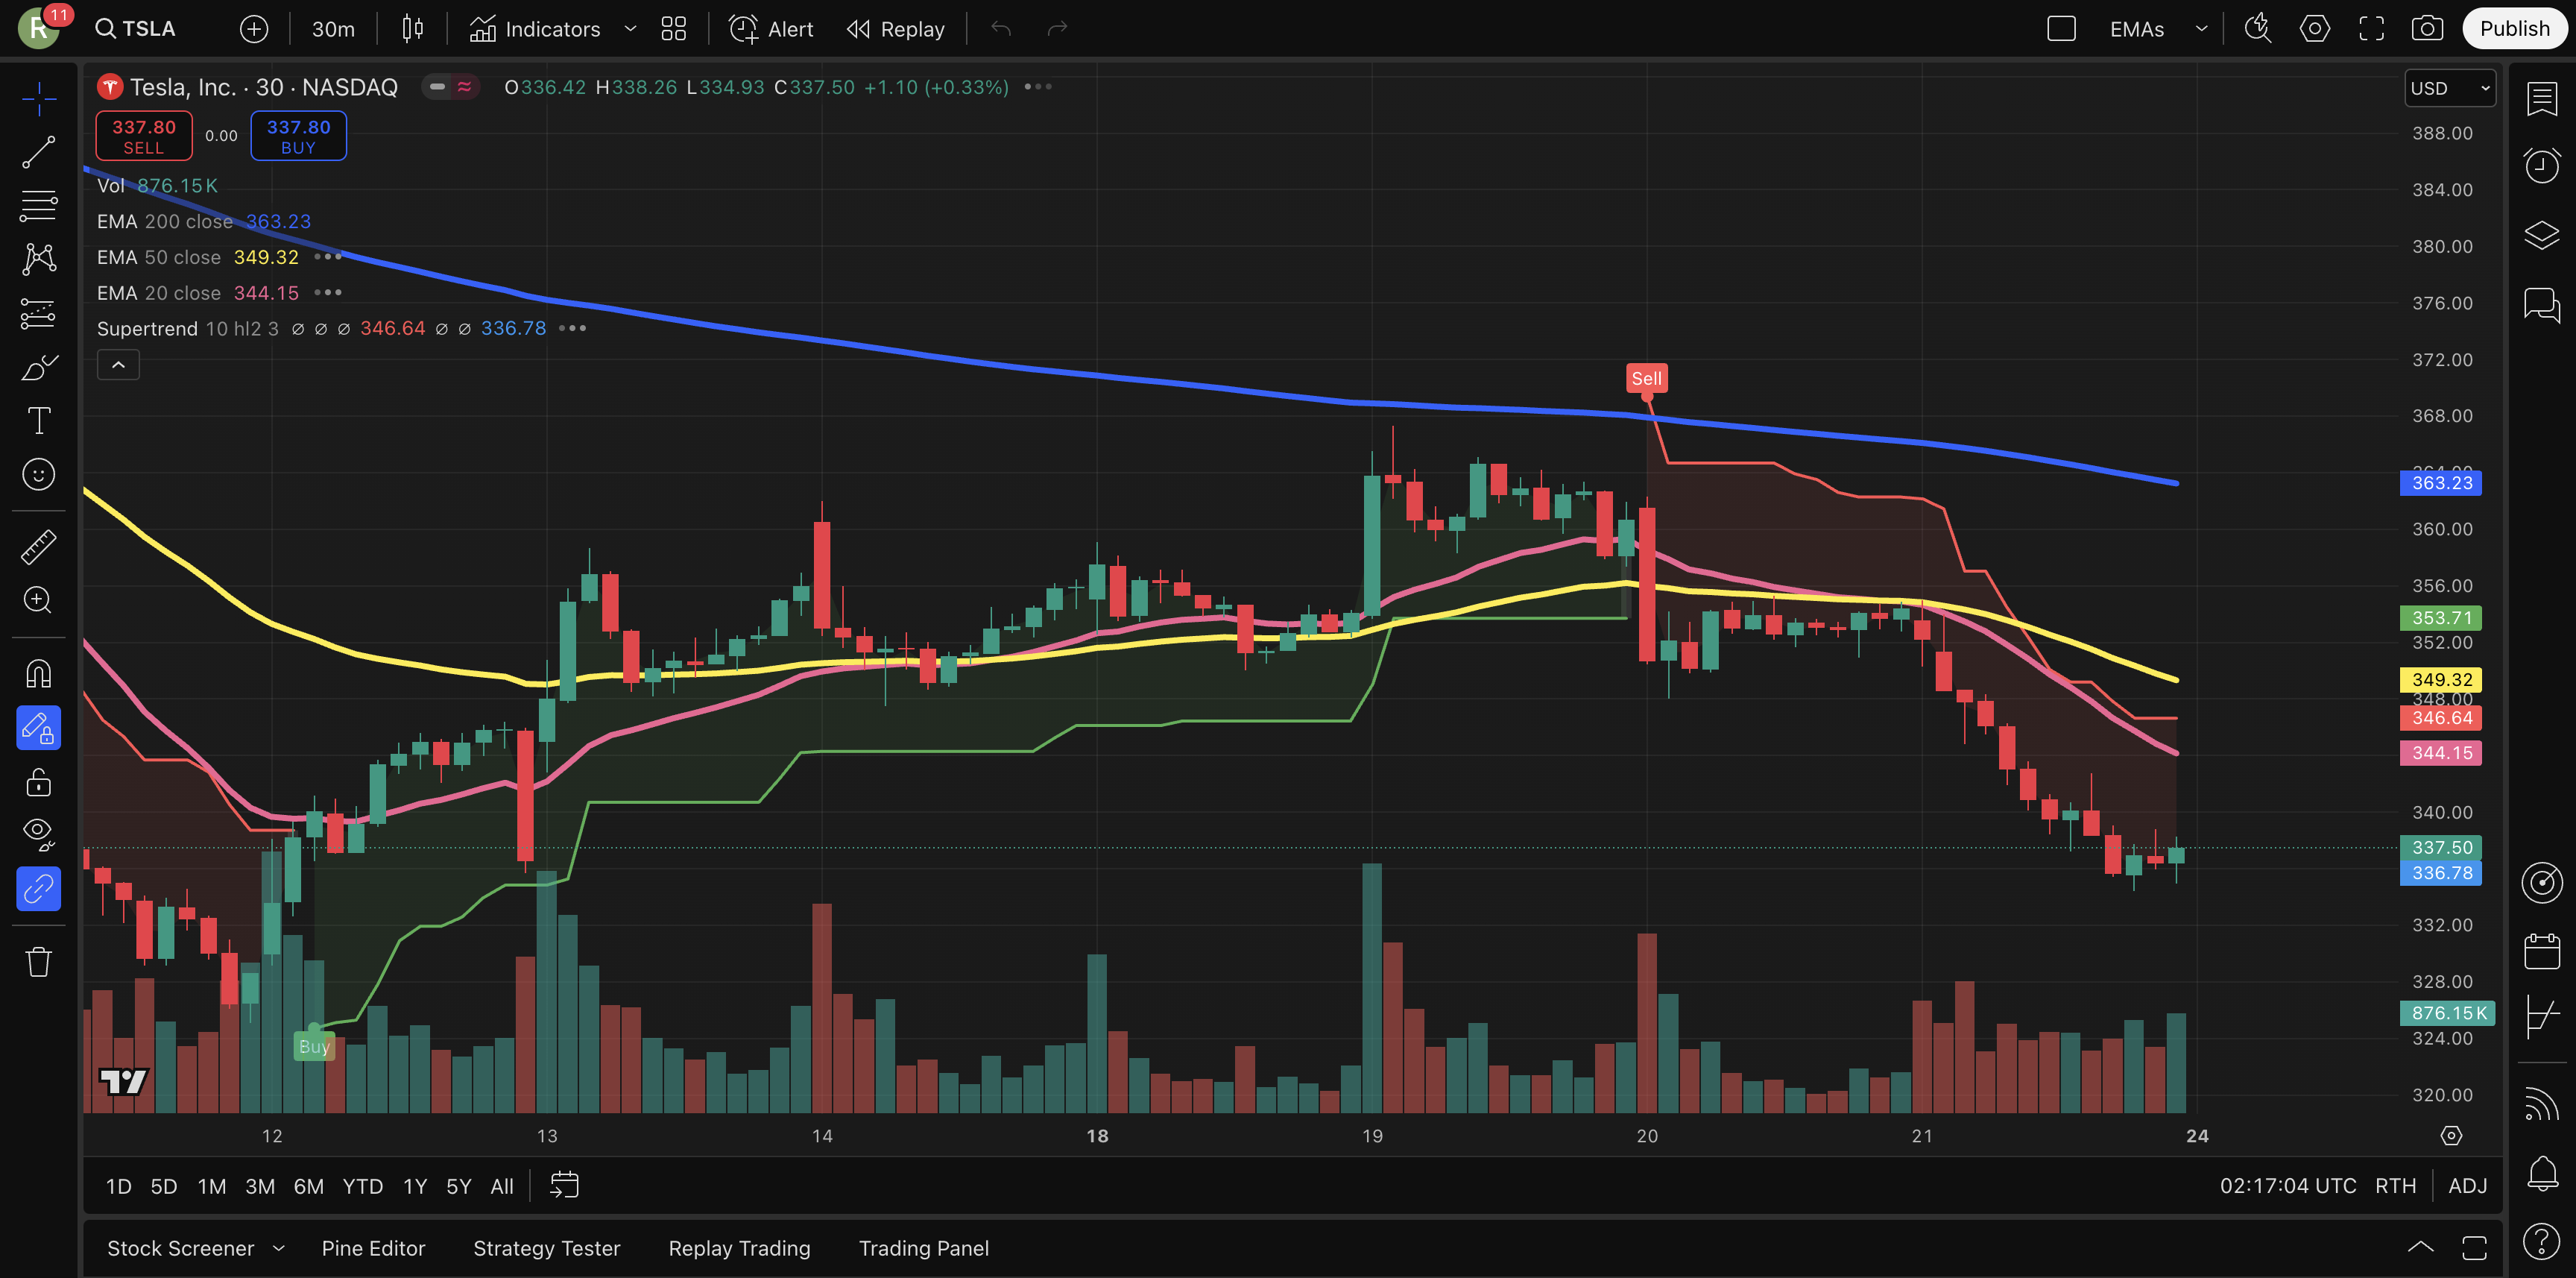

Based on the provided chart for Tesla stock (TSLA), here's an analysis of the trends and EMAs, along with suggestions for low-risk and high-risk options trading strategies:

Analysis:
1. The stock is currently trading at $337.50, showing a slight increase of 0.33%.
2. The 200-day EMA is at 363.23, significantly above the current price, indicating a longer-term bearish trend.
3. The 50-day EMA at 349.32 and 20-day EMA at 344.15 are both above the current price, suggesting a short-term bearish trend as well.
4. The price has been consolidating in a narrow range between roughly $334 and $338 over the past few days.
5. The Supertrend indicator shows support at 336.78, close to the current price.

Low-risk options strategy to collect premiums:
Given the bearish trend and consolidation, a low-risk strategy would be to sell cash-secured puts slightly out-of-the-money (OTM).

Strategy: Cash-secured put
- Sell a put option with a strike price of $330, about 2% OTM
- Choose an expiration date 2-

In [20]:
persist_chart_for_analysis(url, image_path)
# Display the saved image
display(Image(filename=image_path))
processed_data = image_to_analysis(image_path)
messages = [{
    "role": "user",
    "content": f"""Analyze this data, describing the trends and EMAs and suggest a low-risk options trading strategy to profit from collecting premiums, as well as a high-risk one to profit from a rapid move if it seems possible:
    
    ## 
    {processed_data}
    """
}]
AIopinion(messages=messages)

In [11]:
print(processed_data)

& QTSLA @ 30m {lt | 4h indicators ~ 88 @ Alert <d Replay EMAs. ~ & ) (3 (©) Gen
_|_ | @Tesla, Inc.-30-NASDAQ “== 0336.42 H338.26 L334.93 C337.50 +1.10 (+0.33%) USD» =I
I
| 337.80 awa [ 237,8° | 15.00%
J. SELL BUY 6)
—_— 6IS8Z6.15K 14.00%
—
e— | EMA 200 clo 67% 13.00% <>
BX EMA 50 close 3.54%
5 12.00%
om EMA 20 close 2.01% Ly
= Supertrend 10 hlI23 @ @ @ 2.75% @ @ -0.18% eee 11.00%
Ly = 10.00%
T 9.00%
°
© { Pha jam
7m o 7.00%
2 i ‘ l + ~ 6.00%
L : = 4.00%
a
"t
te cat
Oo MBooBWo
ih, L -1.00% ©)
nl -2.00% FS
~3.00% "
: ) Lihue il | ll il lnttaale! or
e,
HERRAFRGERDFGoQTANGERH Modan PBQGQrGooHeMBQQU roca enon QH4000QteeBoUNGQQiuronntevSdQ0QIGQQINE> som | 5
24 ©
1D 5D 1M 3M 6M YTD 1Y 5BY All Ss 02:04:42 UTC RTH | ADJ O
Stock Screener ~ Pine Editor Strategy Tester Replay Trading Trading Panel ~ oO


In [12]:
messages = [{
    "role": "user",
    "content": f"""Analyze this data:
    
    ## 
    {processed_data}
    """
}]

In [13]:
AIopinion(messages=messages)

Based on the chart data provided, here's an analysis of Tesla (TSLA) stock:

1. Current price: The stock is currently trading at $337.50, up 1.10 (+0.33%) for the session.

2. Price range: The day's trading range has been between a low of $334.93 and a high of $338.26.

3. Moving averages:
   - EMA 200: The 200-period exponential moving average is showing a 6.67% gain.
   - EMA 50: The 50-period EMA indicates a 3.54% increase.
   - EMA 20: The 20-period EMA shows a 2.01% rise.

4. Supertrend indicator: The Supertrend 10 high/low/close is at 2.75%, suggesting a bullish trend.

5. Volume: The trading volume appears to be relatively high, as indicated by the volume bars at the bottom of the chart.

6. Overall trend: The stock seems to be in an uptrend, with the price above all shown EMAs and the Supertrend indicator positive.

7. Time frame: This is a 30-minute chart, providing a short-term view of the stock's performance.

8. Market sentiment: The buy/sell indicator at the top of the cha